# Preprocessing Input

In [1]:
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from skimage.util import random_noise
from scipy.stats import norm
import cv2
np.random.seed(42)

In [4]:
# INPUT folder (make sure all dataset are stored in this path)
FILE_PATH = 'JPEGImages/'

# INPUT folder (lower resolution and square dimension)
IN_PATH = 'DATAImages/'

# OUTPUT folder 
OUT_PATH = 'NOISEImages/' 

# INPUT Dimension
SIZE = (256, 256)

def lower_resolution(PATH=FILE_PATH, OUT=IN_PATH, size = SIZE):
    ''' Lower resolution and Square Dimension '''
    # Create output directory, overwrite if exists
    shutil.rmtree(OUT, ignore_errors=True)
    os.makedirs(OUT)

    for i in os.listdir(PATH):
        if i.endswith('.jpg'):
            # transform color to greyscale
            res_img = Image.open(os.path.join(PATH, i)).convert('L')
            res_img = np.array(res_img.resize(size, Image.ANTIALIAS))

            cv2.imwrite(os.path.join(OUT,i), res_img)

def noise_addition(PATH=IN_PATH, OUT=OUT_PATH, mode="gauss", grey = False, prob = 0.2):
    ''' Add noise to the dataset and store in a directory'''
    # Create output directory, overwrite if exists
    shutil.rmtree(OUT, ignore_errors=True)
    os.makedirs(OUT)
    
    for i in os.listdir(PATH):
        if i.endswith('.jpg'):
            # Load the image
            if grey:
                img = cv2.imread(os.path.join(PATH,i), cv2.IMREAD_GRAYSCALE) 
            else:
                img = cv2.imread(os.path.join(PATH,i))
            
            out_img = 0
        
            if mode == "sp":
                # Add salt-and-pepper noise
                noise = random_noise(img, mode='s&p',amount=prob)
                out_img = np.array(255 * noise, dtype = 'uint8')
            elif mode == "gauss":
                # Add Gaussian noise
                gauss = np.random.normal(0,1,img.size)
                gauss = gauss.reshape(img.shape[0],img.shape[1])
                out_img = img + 10 * gauss
            cv2.imwrite(os.path.join(OUT,i), out_img)

lower_resolution()
noise_addition(grey=True, mode="sp", prob=0.01)


# Total Variation with GrayScale

(256, 256)
(256, 256)


(-0.5, 255.5, 255.5, -0.5)

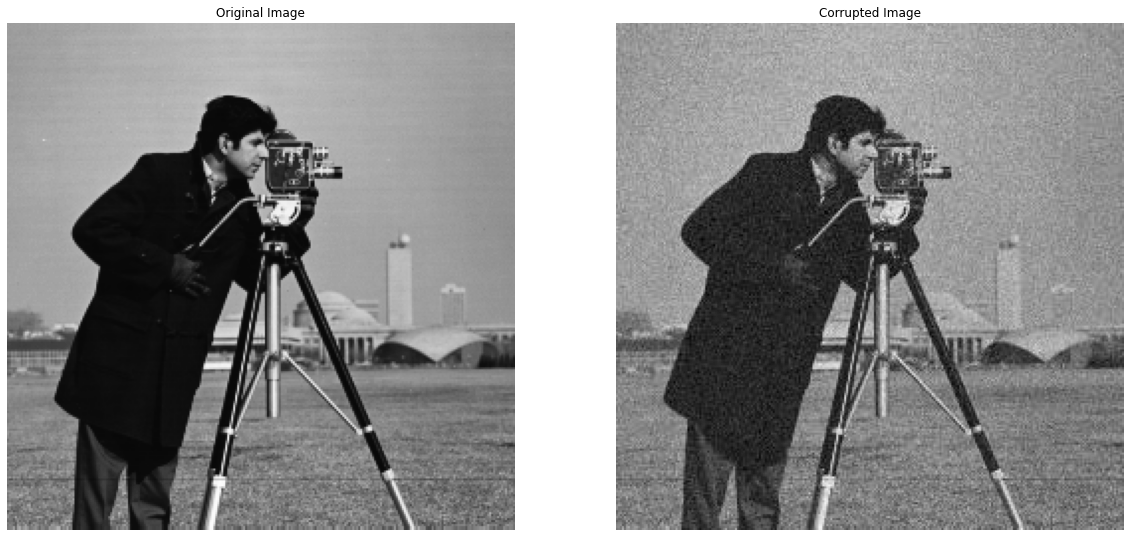

In [3]:
# Load the images.
orig_img = Image.open("cameraman.tif").convert('L')
corr_img = Image.open("cameramanNoise.jpg")
print(orig_img.size)
print(corr_img.size)

# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(orig_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

In [3]:
def denoise(img, lam=1):
    ''' OBJ = Fidelity term + Lambda * Total variation of gradient '''
    ''' Constraint: '''
    var = cp.Variable(img.shape)

    # fidelity term
    fid = 0.5 * cp.sum_squares(var - img)

    # regularization term
    reg = cp.tv(var)

    # objective
    obj =  cp.Minimize(fid + lam * reg)
    prob = cp.Problem(obj, constraints = [])
    prob.solve(verbose = True, solver = 'SCS')

    return var.value

In [5]:
result = denoise(Ucorr, lam=5)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 06 01:29:12 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Mar 06 01:29:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 06 01:29:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 06 01:29:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 06 01:29:12 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 06 01:29:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(-0.5, 255.5, 255.5, -0.5)

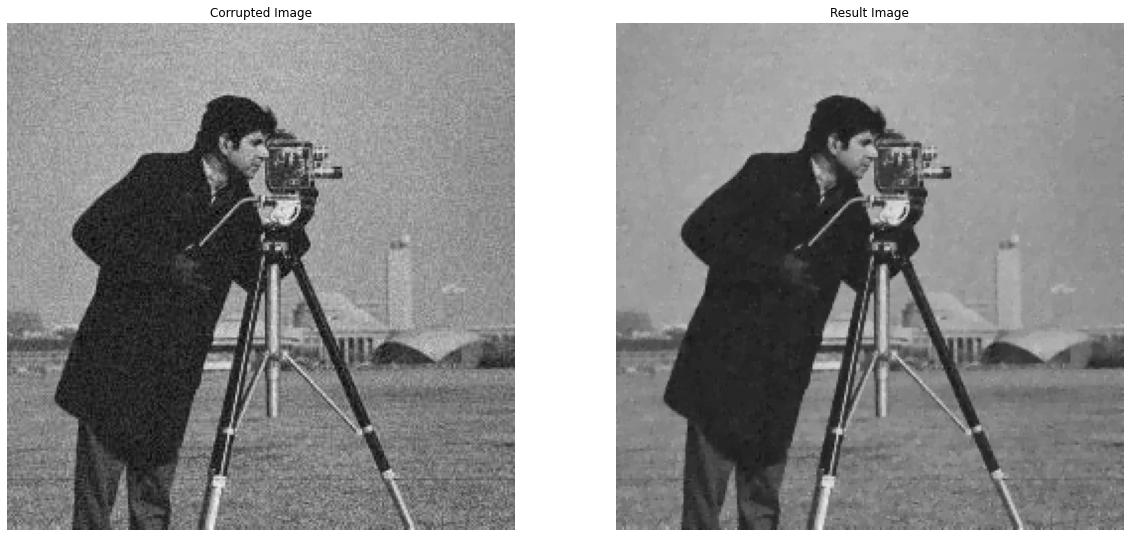

In [6]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')

# Experiment

In [8]:
lambda_list = [0.1, 0.5, 1.0, 2.0, 5.0]
result_list = []
diff_list = []

for lam in lambda_list:
    result_list.append(denoise(Ucorr, lam))
    diff_list.append(np.sum(np.abs(Uorig - result_list[-1])))

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 06 01:31:54 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Mar 06 01:31:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 06 01:31:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 06 01:31:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 06 01:31:54 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 06 01:31:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

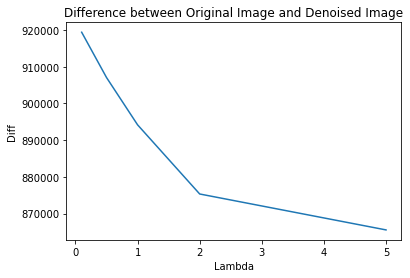

In [12]:
plt.title('Difference between Original Image and Denoised Image')
plt.xlabel('Lambda')
plt.ylabel('Diff')
plt.plot(lambda_list, diff_list)
plt.show()

(496, 500)
(256, 256)


(-0.5, 255.5, 255.5, -0.5)

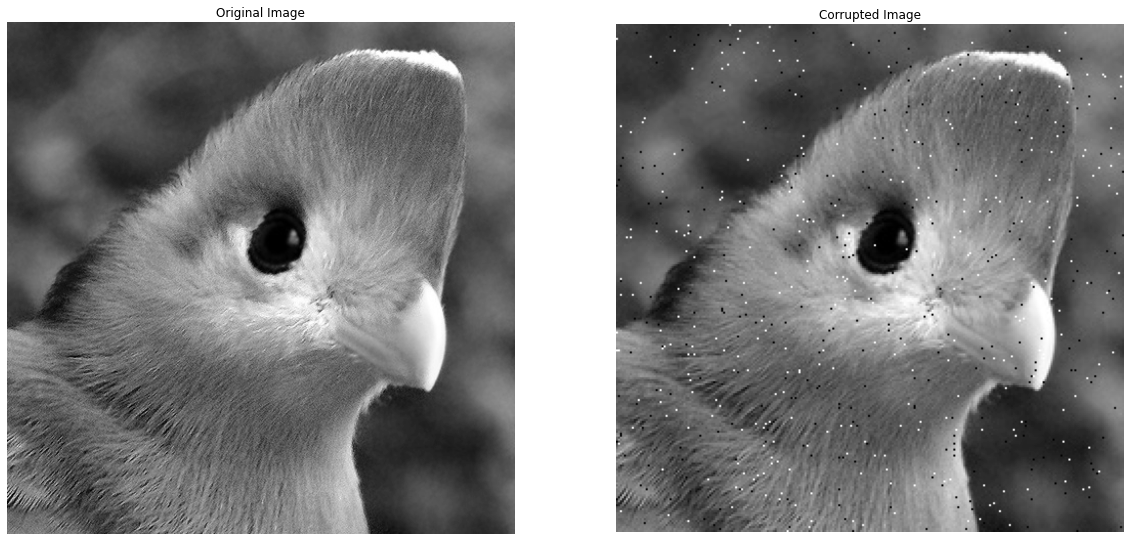

In [8]:
# Load the images.
orig_img = Image.open("JPEGImages/000064.jpg").convert('L')
corr_img = Image.open("NOISEImages/000064.jpg")
print(orig_img.size)
print(corr_img.size)

# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(orig_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

In [9]:
result = denoise(Ucorr, lam=5)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 09 02:11:07 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Mar 09 02:11:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 02:11:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 02:11:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 02:11:07 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 09 02:11:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(-0.5, 255.5, 255.5, -0.5)

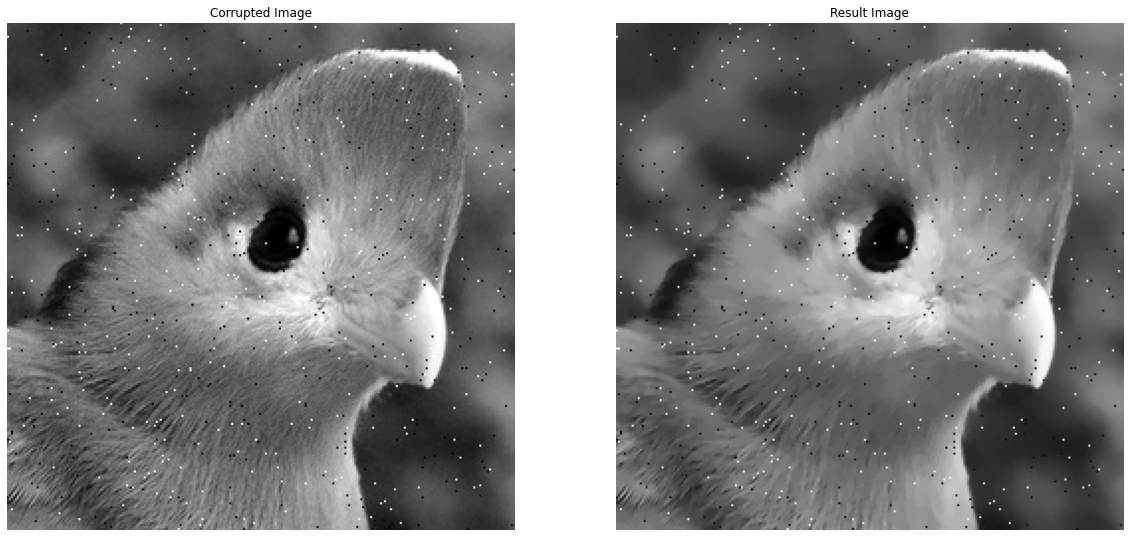

In [10]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')